<a href="https://colab.research.google.com/github/singhnikhil01/AICanPlay/blob/main/Features_captured_graph_stracture_error_solved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sacremoses
!pip install torch_geometric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.5 MB/s eta 0:00:00


In [2]:
import time
import re
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.nn import functional as F
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from typing import Dict, List, Set
from collections import defaultdict

# from grakel import graph_from_networkx
# from grakel.kernels import WeisfeilerLehman, VertexHistogram, ShortestPath, PyramidMatch

class GraphProcessor:
    def __init__(self, min_freq: int = 7, chars_to_retain: int = 3):
        self.min_freq = min_freq
        self.chars_to_retain = chars_to_retain
        self.label_counts = defaultdict(int)
        self.final_labels: Set[str] = set()

    def preprocess_graphs(self, Gs: Dict[int, nx.DiGraph]) -> List[nx.DiGraph]:
        processed_graphs = {}
        icd_pattern = re.compile(r"[A-TV-Z][0-9][0-9AB]\.?[0-9A-TV-Z]{0,4}")

        for idx, G in Gs.items():
            graph = G.copy()
            to_remove = set()
            label_to_node = {}

            # Process nodes in a single pass
            for node in graph.nodes():
                node_data = graph.nodes[node]
                node_label = node_data.get("label", "")

                if node_label == "Condition":
                    self._process_condition_node(
                        graph, node, to_remove, label_to_node,
                        icd_pattern
                    )
                elif node_label == "MedicationRequest":
                    if not list(graph.successors(node)):
                        to_remove.add(node)

            # Remove nodes and update graph
            graph.remove_nodes_from(to_remove)
            processed_graphs[idx] = graph

            # Update label counts
            for node in graph.nodes():
                self.label_counts[graph.nodes[node].get("label", "")] += 1

        # Filter frequent labels
        self.final_labels = {
            label for label, count in self.label_counts.items()
            if count > self.min_freq
        }

        # Final graph refinement
        return self._refine_graphs(processed_graphs)

    def _process_condition_node(
        self,
        graph: nx.DiGraph,
        node: int,
        to_remove: Set[int],
        label_to_node: Dict[str, int],
        icd_pattern: re.Pattern
    ) -> None:

        successors = list(graph.successors(node))
        if len(successors) != 1:
            to_remove.add(node)
            return

        successor = successors[0]
        code = graph.nodes[successor].get("code", "")[:4]

        if not icd_pattern.match(code):
            to_remove.update({successor, node})
            return

        # Update node label
        new_label = code[:self.chars_to_retain]
        graph.nodes[successor]["label"] = new_label

        # Handle duplicate labels
        if new_label in label_to_node:
            if label_to_node[new_label] != successor:
                to_remove.add(successor)
                graph.add_edge(node, label_to_node[new_label])
        else:
            label_to_node[new_label] = successor

    def _refine_graphs(self, Gs: Dict[int, nx.DiGraph]) -> List[nx.DiGraph]:
        """Final refinement of graphs with optimized processing"""
        refined_graphs = []

        for G in Gs.values():
            nodes_to_remove = set()

            # Process nodes in a single pass
            for node in G.nodes():
                node_data = G.nodes[node]
                if node_data.get("label") in {"Condition"}:
                    predecessors = list(G.predecessors(node))
                    successors = list(G.successors(node))

                    if len(predecessors) != 1 or len(successors) != 1:
                        nodes_to_remove.add(node)
                        continue

                    # Check if successor's label is frequent enough
                    if G.nodes[successors[0]]["label"] in self.final_labels:
                        G.add_edge(predecessors[0], successors[0])
                    else:
                        nodes_to_remove.add(successors[0])
                    nodes_to_remove.add(node)

            # Remove nodes and add end node
            G.remove_nodes_from(nodes_to_remove)
            G.add_node("end_node", label="EndNode")

            # Find last encounter and connect to end node
            encounters = [
                node for node in G.nodes()
                if G.nodes[node]["label"] == "Encounter"
            ]
            subG = G.subgraph(encounters)
            last_encounter = next(
                node for node in encounters
                if len(list(subG.successors(node))) == 0
            )
            G.add_edge(last_encounter, "end_node")

            refined_graphs.append(G)

        return refined_graphs

In [3]:
  import json
  import torch
  import numpy as np
  import networkx as nx
  from transformers import AutoTokenizer

  class GraphBatch:
      def __init__(self, model="microsoft/BioGPT"):
          self.tokenizer = AutoTokenizer.from_pretrained(model)
          self.node_label_mapping  = {"Patient": 0, "EndNode": 1, "Encounter": 2 }
          self.n_chain_labels = 3
          self.n_star_labels = 0

      def _extract_node_features(self, node_data: dict) -> tuple:

          concatenated_features = str(node_data)
          tokenized = self.tokenizer(
              concatenated_features,
              return_tensors="pt",
              padding=True,
              truncation=True,
              max_length=128,
              add_special_tokens=True
          )
          return tokenized['input_ids'].squeeze(0), tokenized['attention_mask'].squeeze(0)

      def create_batches(self, Gs, batch_size, device, shuffle=False,n_star_labels=0):
          n_samples = len(Gs)
          idx = np.random.permutation(n_samples) if shuffle else np.arange(n_samples)

          edge_index_chain, edge_index_star, features_batch_list, attention_mask_list, label_batch_list = [], [], [], [], []
          last_node, node_indicator = [], []
          max_star, max_chain = 0, 0

          for i in range(0, n_samples, batch_size):
              Gs_batch, top_sort, last_node_batch = [], [], []
              n_nodes_batch, max_chain_batch = 0, 0

              for j in range(i, min(i + batch_size, n_samples)):
                  nodes_in_chain = [
                      node for node in Gs[idx[j]].nodes()
                      if Gs[idx[j]].nodes[node]["label"] in [0, 1, 2]
                  ]

                  chain = Gs[idx[j]].subgraph(nodes_in_chain)
                  ts = list(nx.topological_sort(chain))

                  ts_processed, to_remove = [ts[0]], []
                  for k in range(1, len(ts) - 1):
                      if Gs[idx[j]].out_degree(ts[k]) - 1 > 0:
                          ts_processed.append(ts[k])
                      else:
                          to_remove.append(ts[k])

                  ts_processed.append(ts[-1])

                  if to_remove:
                      for node in to_remove:
                          Gs[idx[j]].remove_node(node)
                      for k in range(len(ts_processed) - 1):
                          Gs[idx[j]].add_edge(ts_processed[k], ts_processed[k + 1])
                      ts = ts_processed

                  for node in ts[1:-1]:
                      max_star = max(max_star, Gs[idx[j]].out_degree(node) - 1)

                  mapping = {node: k + n_nodes_batch for k, node in enumerate(ts)}
                  for node in Gs[idx[j]].nodes():
                      if node not in mapping:
                          mapping[node] = len(mapping) + n_nodes_batch

                  G = nx.relabel_nodes(Gs[idx[j]], mapping)
                  Gs_batch.append(G)
                  ts = [k + n_nodes_batch for k in range(len(ts))]
                  top_sort.append(ts)
                  last_node_batch.append(ts[-1])
                  max_chain_batch = max(max_chain_batch, len(ts))
                  n_nodes_batch += G.number_of_nodes()

              max_chain = max(max_chain_batch, max_chain)

              try:
                  features_batch = torch.zeros((n_nodes_batch, 128), dtype=torch.long)  # Changed from 512 to 128
                  attention_mask_batch = torch.zeros((n_nodes_batch, 128), dtype=torch.long)  # Added attention mask
                  label_batch = torch.zeros(n_nodes_batch, dtype=torch.long)
                  node_ind = torch.zeros(n_nodes_batch, dtype=torch.long)

                  for j, G in enumerate(Gs_batch):
                      for node in G.nodes():
                          node_features = G.nodes[node]
                          node_feature_tensor, attention_mask_tensor = self._extract_node_features(node_features)
                          node_feature_tensor = node_feature_tensor[:128]  # Changed from 512 to 128
                          attention_mask_tensor = attention_mask_tensor[:128]  # Truncate attention mask

                          if node_feature_tensor.size(0) < 128:  # Changed from 512 to 128
                              padding_size = 128 - node_feature_tensor.size(0)  # Changed from 512 to 128
                              node_feature_tensor = torch.nn.functional.pad(
                                  node_feature_tensor, (0, padding_size)
                              )
                              attention_mask_tensor = torch.nn.functional.pad(
                                  attention_mask_tensor, (0, padding_size)
                              )

                          features_batch[node] = node_feature_tensor.long()
                          attention_mask_batch[node] = attention_mask_tensor.long()
                          label_batch[node] = G.nodes[node]["label"]
                          node_ind[node] = j

                  features_batch_list.append(features_batch.to(device))
                  attention_mask_list.append(attention_mask_batch.to(device))
                  label_batch_list.append(label_batch.to(device))
                  last_node.append(torch.LongTensor(last_node_batch).to(device))
                  node_indicator.append(node_ind.to(device))

                  edges_chain = [[] for _ in range(max_chain_batch - 1)]
                  edges_star = [[] for _ in range(max_chain_batch - 1)]

                  for j in range(max_chain_batch - 1):
                      for k in range(len(Gs_batch)):
                          if len(top_sort[k]) > j:
                              for successor in Gs_batch[k].successors(top_sort[k][j]):
                                  if Gs_batch[k].nodes[successor]["label"] in [1, 2]:
                                      if not (j == 0 and successor != top_sort[k][j + 1]):
                                          edges_chain[j].append((top_sort[k][j], successor))
                                  else:
                                      edges_star[j].append((successor, top_sort[k][j]))

                      edges_chain[j] = (
                          torch.LongTensor(np.vstack(edges_chain[j])).to(device)
                          if edges_chain[j]
                          else torch.empty((0, 2), dtype=torch.long).to(device)
                      )
                      edges_star[j] = (
                          torch.LongTensor(np.vstack(edges_star[j])).to(device)
                          if edges_star[j]
                          else torch.empty((0, 2), dtype=torch.long).to(device)
                      )

                  edge_index_chain.append(edges_chain)
                  edge_index_star.append(edges_star)

              except Exception as e:
                  print(f"Error processing batch {i}: {str(e)}")
                  continue

          return {
              'edge_index_chain': edge_index_chain,
              'edge_index_star': edge_index_star,
              'features': features_batch_list,
              'attention_mask': attention_mask_list,
              'labels': label_batch_list,
              'node_indicator': node_indicator,
              'last_node': last_node,
              'max_chain': max_chain,
              'node_feature_dim': 128
          }

# Moldel

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoModel, AutoConfig

class FeatureProcessor(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        num_layers: int = 2,
        num_attention_heads: int = 8,
        dropout_rate: float = 0.2,
        model: str = "microsoft/BioGPT"
    ):
        super().__init__()
        self.config = AutoConfig.from_pretrained(model)
        self.input_projection = nn.Linear(hidden_dim, self.config.hidden_size)
        self.output_projection = nn.Linear(self.config.hidden_size, hidden_dim)

        # Transformer encoder
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.config.hidden_size,
                nhead=num_attention_heads,
                dim_feedforward=self.config.intermediate_size,
                dropout=dropout_rate,
                activation=F.gelu,
                batch_first=True
            ),
            num_layers=num_layers
        )

        # Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(
                d_model=self.config.hidden_size,
                nhead=num_attention_heads,
                dim_feedforward=self.config.intermediate_size,
                dropout=dropout_rate,
                activation=F.gelu,
                batch_first=True
            ),
            num_layers=num_layers
        )

        self.context_encoder = nn.Sequential(
            nn.Linear(self.config.hidden_size * 2, self.config.hidden_size),
            nn.LayerNorm(self.config.hidden_size),
            nn.GELU(),
            nn.Dropout(dropout_rate)
        )

        self.positional_encoding = nn.Parameter(
            torch.randn(1, 512, self.config.hidden_size) * 0.02
        )


    def forward(
        self,
        node_features: torch.Tensor,
        attention_mask: torch.Tensor = None
    ) -> torch.Tensor:
        x = self.input_projection(node_features)

        if attention_mask is None:
            attention_mask = torch.ones_like(node_features[:,:,0], dtype=torch.bool)
        seq_length = x.size(1)
        x = x + self.positional_encoding[:, :seq_length, :]
        encoder_output = self.transformer_encoder(
            x,
            src_key_padding_mask=~attention_mask
        )
        encoder_repr = encoder_output.mean(dim=1)
        output = self.output_projection(encoder_repr)
        return output


    def decode_features(
        self,
        context: torch.Tensor,
        max_length: int,
        temperature: float = 1.0
    ) -> torch.Tensor:
        context = self.input_projection(context)

        batch_size = context.size(0)
        decoder_input = torch.zeros(
            batch_size,
            max_length,
            self.config.hidden_size,
            device=context.device
        )
        decoder_input = decoder_input + self.positional_encoding[:, :max_length, :]
        decoder_output = self.transformer_decoder(
            tgt=decoder_input,
            memory=context.unsqueeze(1)
        )
        decoder_output = self.output_projection(decoder_output)

        return decoder_output

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import networkx as nx
from torch_geometric.nn import GCNConv
from transformers import AutoTokenizer
from typing import List, Tuple, Optional, Dict, Any

class NeuralNet(nn.Module):
    def __init__(
        self,
        hidden_dim: int,
        latent_dim: int,
        max_chain: int,
        n_chain_labels: int,
        n_star_labels: int,
        node_feature_dim: int,
        device: torch.device,
        dropout_rate: float = 0.2,
        model: str = "microsoft/BioGPT",
        num_layers: int = 4
    ):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.device = device
        self.max_chain = max_chain
        self.n_chain_labels = n_chain_labels
        self.n_star_labels = n_star_labels
        self.node_feature_dim = node_feature_dim
        self.num_layers = num_layers

        # Initialize tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model)
        self.pad_token_id = self.tokenizer.pad_token_id
        self.vocab_size = self.tokenizer.vocab_size

        # Feature processing
        self.feature_combiner = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Embeddings
        self.label_embedding = nn.Embedding(n_chain_labels + n_star_labels, hidden_dim)
        self.token_embedding = nn.Embedding(self.vocab_size, hidden_dim, padding_idx=self.pad_token_id)

        # Graph layers
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.layer_norm = nn.LayerNorm(hidden_dim)

        # Encoder components
        self.gru_enc = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # Decoder components
        self.gru_dec = nn.GRUCell(hidden_dim, hidden_dim)
        self.fc_decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim*2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Node prediction components
        self.add_node_chain = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 3),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 3,hidden_dim ),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim , n_chain_labels)
        )


        # adding the start nodes to the chain nodes
        self.add_node_star = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 6),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim * 6, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim , n_star_labels)
        )

        # Feature processing
        self.feature_encoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate,
            bidirectional=True
        )

        self.feature_decoder = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate
        )

        self.feature_context_proj= nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )

        # Token prediction
        self.token_predictor = nn.Linear(hidden_dim, self.vocab_size)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def encode_features(
        self,
        node_features: torch.Tensor,
        attention_mask: torch.Tensor
    ) -> torch.Tensor:

        # Embed tokens
        embedded_features = self.token_embedding(node_features)
        embedded_features = embedded_features * attention_mask.unsqueeze(-1)

        # Process through LSTM
        output, (h_n, _) = self.feature_encoder(embedded_features)

        # Combine forward and backward states
        fwd_state = h_n[-2,:,:]
        bwd_state = h_n[-1,:,:]

        return torch.cat([fwd_state, bwd_state], dim=-1)

    def encode(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        attention_mask: torch.Tensor,
        last_node: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        last_node = last_node.to(torch.int64)
        batch_size = x.size(0)

        # Initialize states
        h = torch.zeros(batch_size, self.hidden_dim, device=self.device)
        m = torch.zeros(batch_size, self.hidden_dim, device=self.device)

        # Encode features
        encoded_features = self.encode_features(node_features, attention_mask)
        encoded_features = self.feature_combiner(encoded_features)

        # Combine features with label embeddings
        label_embeddings = self.label_embedding(x)
        combined_features = self.feature_context_proj(
            torch.cat([encoded_features, label_embeddings], dim=-1)
        )

                # Process star nodes with residual connections
        for i in range(1, len(edge_index_star)):
            if edge_index_star[i] is not None and edge_index_star[i].size(0) > 0:
                unique = torch.unique(edge_index_star[i][:, 1])

                h.scatter_add_(
                    0,
                    edge_index_star[i][:, 1].unsqueeze(1).expand(-1, self.hidden_dim).long(),
                    combined_features[edge_index_star[i][:, 0].long()]
                )

                unique = unique.long()
                h[unique] = self.gru_enc(combined_features[unique].float(), h[unique])

                edge_index_star[i] = edge_index_star[i].to(torch.int64)
                h_conv = self.conv1(h, edge_index_star[i].T)
                h_conv = F.relu(h_conv)
                h_conv = self.conv2(h_conv, edge_index_star[i].T)
                h = self.layer_norm(h + h_conv)

        for edge_index in edge_index_chain:
            if edge_index is not None and edge_index.size(0) > 0:
                unique = torch.unique(edge_index[:, 0]).to(torch.int64)
                h[unique] = self.gru_enc(h[unique], m[unique])
                m[edge_index[:, 1].to(torch.int64)] += h[edge_index[:, 0].to(torch.int64)]

        h[last_node] = self.gru_enc(combined_features[last_node], m[last_node])
        h_g = h[last_node]
        return self.fc_mu(h_g), self.fc_logvar(h_g)

    def reparameterize(
        self,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        eps_scale: float = 1.0
    ) -> torch.Tensor:
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std) * eps_scale
            return mu + eps * std
        return mu


    def decode_features(
        self,
        h: torch.Tensor,
        max_length: int,
        temperature: float = 1.0
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        batch_size = h.size(0) if h.dim() > 1 else 1
        if h.dim() == 1:
            h = h.unsqueeze(0)

        h_0 = h.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        curr_token = torch.full(
            (batch_size, 1),
            self.pad_token_id + 1,
            device=self.device
        )

        generated_tokens = []
        token_logits = []

        for _ in range(max_length):
            token_embedding = self.token_embedding(curr_token)
            output, (h_0, c_0) = self.feature_decoder(token_embedding, (h_0, c_0))
            logits = self.token_predictor(output.squeeze(1)) / temperature

            if self.training:
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
            else:
                next_token = logits.argmax(dim=-1, keepdim=True)

            generated_tokens.append(next_token)
            token_logits.append(logits)
            curr_token = next_token

        return (torch.cat(generated_tokens, dim=1),
                torch.stack(token_logits, dim=1))

    def decode(
        self,
        z: torch.Tensor,
        stochastic: bool = False,
        temperature: float = 1.0
    ) -> List[nx.DiGraph]:
        """
        doing the better capturing of the node features , but graph stracture is not captured, and not properly handled
        """
        batch_size = z.size(0)
        h0 = self.relu(self.fc_decoder(z))
        h_graph = torch.zeros(batch_size, self.hidden_dim, device=z.device)

        graphs = [nx.DiGraph() for _ in range(batch_size)]
        for G in graphs:
            G.add_node(0, label=0)

        # Generate root node features
        root_label = torch.tensor([0] * len(graphs), device=z.device)
        root_embedding = self.label_embedding(root_label)

        # Combine label embedding with latent representation for feature generation
        root_context = torch.cat([root_embedding, h0], dim=-1)
        root_context = self.feature_context_proj(root_context)

        # Generate root node features
        root_features, _ = self.decode_features(
            root_context,
            max_length=self.node_feature_dim,
            temperature=temperature
        )

        h_graph = self.gru_dec(root_embedding, h0)  # Initialize graph state

        for i, G in enumerate(graphs):
            G.nodes[0]["features"] = root_features[i].detach().cpu().numpy()


        active_graph = [True] * batch_size #active for the graph generation , here the batch_size will be nothhing but the number of batch of the graphs to be generated

        # for chain node generatoin
        for node_idx in range(1, self.max_chain):
            active_idx = [i for i, active in enumerate(active_graph) if active]
            if not active_idx:
                break


            active_prev_labels = torch.tensor([
                    graphs[i].nodes[node_idx - 1]["label"]
                    for i in active_idx], dtype=torch.long, device=self.device)


            active_embeddings = self.label_embedding(active_prev_labels)
            active_h0 = h0[active_idx]

            h_graph = self.gru_dec(active_embeddings, active_h0)
            node_label_scores = self.add_node_chain(h_graph)

            if stochastic:
                probs = F.softmax(node_label_scores / temperature, dim=1)
                new_node_labels = torch.multinomial(probs, 1).flatten().tolist()
            else:
                new_node_labels = torch.argmax(node_label_scores, dim=1).tolist()

            # Add nodes and edges to graphs
            for batch_idx, graph_idx in enumerate(active_idx):
                    G = graphs[graph_idx]
                    label = new_node_labels[batch_idx]+1

                    # Add chain node
                    G.add_node(node_idx, label=label)
                    G.add_edge(node_idx - 1, node_idx)

                    # Generate node features based on label and latent space
                    label_tensor = torch.tensor([label], device=z.device)
                    label_embedding = self.label_embedding(label_tensor)

                    # Combine label embedding with latent representation
                    node_context = torch.cat([
                        label_embedding,
                        h0[graph_idx:graph_idx+1]
                    ], dim=-1)

                    node_context = self.feature_context_proj(node_context)

                    # Generate features
                    features, _ = self.decode_features(
                        node_context,
                        max_length=self.node_feature_dim,
                        temperature=temperature
                    )
                    G.nodes[node_idx]["features"] = features[0].detach().cpu().numpy()

                    # Update graph state
                    #h_graph[graph_idx] = self.gru_dec(label_embedding, h0[graph_idx:graph_idx+1])

                    # Terminal node means this is the last of the generation
                    if label == 1:
                        active_graph[graph_idx] = False
                    else:
                        G.add_edge(0, node_idx)  # Connect to root

            # Generate star nodes for active graphs
            star_active_indices = [i for i, active in enumerate(active_graph) if active]
            if star_active_indices and self.n_star_labels > 0:
                     # Similar generation process for star nodes
                    active_labels = torch.tensor([
                              graphs[i].nodes[node_idx]["label"]
                              for i in star_active_indices
                              ], dtype=torch.long, device=z.device)

                    active_embeddings = self.label_embedding(active_labels)
                    active_h0 = h0[star_active_indices]
                    h_star_nodes = self.gru_dec(active_embeddings, active_h0)
                    star_edge_probs = torch.sigmoid(self.add_node_star(h_star_nodes))

                    if stochastic:
                       star_decisions = (star_edge_probs > torch.rand_like(star_edge_probs)).cpu()
                    else:
                       star_decisions = (star_edge_probs > 0.5).cpu()

                    # Add star nodes to graphs
                    for idx, graph_idx in enumerate(star_active_indices):
                        G = graphs[graph_idx]
                        for j, add_star in enumerate(star_decisions[idx]):
                            if add_star:
                                star_node_idx = self.max_chain + j
                                if not G.has_node(star_node_idx):
                                    # Create star node with offset label
                                    star_label = j + self.n_chain_labels
                                    G.add_node(star_node_idx, label=star_label)

                                    # Generate star node features
                                    star_label_tensor = torch.tensor([label], device=z.device)
                                    label_embedding = self.label_embedding(star_label_tensor)

                                    # Combine with latent representation
                                    star_context = torch.cat([
                                        label_embedding,
                                        h0[graph_idx:graph_idx+1]
                                    ], dim=-1)
                                    star_context = self.feature_context_proj(star_context)

                                    # Generate features
                                    features, _ = self.decode_features(
                                        star_context,
                                        max_length=self.node_feature_dim,
                                        temperature=temperature
                                    )
                                    G.nodes[star_node_idx]["features"] = features[0].cpu().numpy()
                                G.add_edge(node_idx, star_node_idx)

        return graphs

    def loss(
        self,
        mu: torch.Tensor,
        logvar: torch.Tensor,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        attention_mask: Optional[torch.Tensor],
        node_ind: torch.Tensor,
        beta: float = 1.0,
        feature_weight: float = 0.5
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:

        z = self.reparameterize(mu, logvar)
        h0 = self.relu(self.fc_decoder(z))
        node_ind = node_ind.to(torch.int64)
        node_features = node_features.float()
        batch_size = z.size(0)

        # Initialize states
        h_nodes = self.label_embedding(x)
        h_graph = torch.zeros(batch_size, self.hidden_dim, device=z.device)

        nll = torch.tensor(0.0, device=z.device)
        feature_recon_loss = torch.tensor(0.0, device=z.device)

        # Process all nodes for feature reconstruction
        for node_idx, label in enumerate(x):
            batch_idx = node_ind[node_idx]
            label_embedding = self.label_embedding(label.unsqueeze(0))
            node_context = torch.cat([
                label_embedding,
                h0[batch_idx:batch_idx+1]
            ], dim=-1)
            node_context = self.feature_context_proj(node_context)

            # Generate features
            _, pred_logits = self.decode_features(
                node_context,
                max_length=self.node_feature_dim,
                temperature=1.0
            )

            # Calculate feature reconstruction loss for this node
            if attention_mask is not None:
                node_mask = attention_mask[node_idx]
            else:
                node_mask = torch.ones_like(node_features[node_idx])

            node_feature_loss = F.cross_entropy(
                pred_logits.view(-1, self.vocab_size),
                node_features[node_idx].view(-1).long(),
                reduction='none'
            )
            feature_recon_loss += (node_feature_loss * node_mask.view(-1)).sum()

        # Process chain structure
        for node_idx in range(len(edge_index_chain)):
            unique_prev = torch.unique(edge_index_chain[node_idx][:, 0])
            node_label_scores = self.add_node_chain(h_graph[node_ind[unique_prev], :])
            unique = torch.unique(edge_index_chain[node_idx][:, 1])
            nll -= F.cross_entropy(node_label_scores, x[unique] - 1, reduction="sum")

            h_nodes[unique, :] = self.gru_dec(
                h_nodes[unique, :], h_nodes[unique_prev, :]
            )

            edge_probs = self.add_node_star(h_nodes[unique[x[unique] != 1], :])
            if edge_probs.size(0) > 0:
                unique = torch.unique(edge_index_star[node_idx + 1][:, 1])
                vals = torch.zeros(
                    torch.max(edge_index_star[node_idx + 1][:, 1]) + 1,
                    dtype=x.dtype,
                    device=z.device,
                )
                vals[unique] = torch.arange(unique.size(0), device=z.device)
                idx = torch.index_select(vals, 0, edge_index_star[node_idx + 1][:, 1])
                ground_truth = torch.zeros(
                    unique.size(0),
                    self.n_star_labels,
                    dtype=edge_probs.dtype,
                    device=z.device,
                )
                ground_truth[
                    idx, x[edge_index_star[node_idx + 1][:, 0]] - self.n_chain_labels
                ] = 1

                nll -= F.binary_cross_entropy(
                    torch.sigmoid(edge_probs), ground_truth, reduction="sum"
                )

                m = torch.zeros(
                    h_nodes.size(0), self.hidden_dim, device=z.device
                ).scatter_add_(
                    0,
                    edge_index_star[node_idx + 1][:, 1]
                    .unsqueeze(1)
                    .repeat(1, self.hidden_dim),
                    h_nodes[edge_index_star[node_idx + 1][:, 0], :],
                )
                h_nodes[unique, :] = self.gru_dec(h_nodes[unique, :], m[unique, :])

            h_graph[node_ind[unique], :] = h_nodes[unique, :]

        # compute loss
        nll = -nll
        kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = nll + beta * kld + feature_recon_loss
        return loss, nll, kld, feature_recon_loss

    def encode_decode(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor,
    ) -> List[nx.DiGraph]:

        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )
        z = self.reparameterize(mu, logvar)
        return self.decode(z, stochastic=False)

    def perturb(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor,
        eps_scale: float = 5.0
    ) -> List[nx.DiGraph]:
        """
        Generate perturbed versions of input graphs.
        """
        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )
        z = mu + eps_scale * torch.randn_like(mu)
        return self.decode(z)

    def forward(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor
    ) -> torch.Tensor:

        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )
        loss, _, _, _ = self.loss(
            mu,
            logvar,
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator
        )
        return loss

    def generate_sample(self, n: int) -> List[nx.DiGraph]:
        z = torch.randn(n, self.latent_dim, device=self.device)
        return self.decode(z, stochastic=True)

    def generate_node_features(self, h: torch.Tensor) -> torch.Tensor:
        return self.feature_decoder(h)

    def save_model(self, path: str) -> None:

        torch.save({
            'model_state_dict': self.state_dict(),
            'model_config': {
                'hidden_dim': self.hidden_dim,
                'latent_dim': self.latent_dim,
                'max_chain': self.max_chain,
                'n_chain_labels': self.n_chain_labels,
                'n_star_labels': self.n_star_labels,
                'node_feature_dim': self.node_feature_dim
            }
        }, path)

    @classmethod
    def load_model(cls, path: str, device: torch.device) -> 'NeuralNet':

        checkpoint = torch.load(path, map_location=device)
        model = cls(
            hidden_dim=checkpoint['model_config']['hidden_dim'],
            latent_dim=checkpoint['model_config']['latent_dim'],
            max_chain=checkpoint['model_config']['max_chain'],
            n_chain_labels=checkpoint['model_config']['n_chain_labels'],
            n_star_labels=checkpoint['model_config']['n_star_labels'],
            node_feature_dim=checkpoint['model_config']['node_feature_dim'],
            device=device
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        return device

    def get_evaluation_metrics(
        self,
        edge_index_chain: List[torch.Tensor],
        edge_index_star: List[torch.Tensor],
        x: torch.Tensor,
        node_features: torch.Tensor,
        node_indicator: torch.Tensor,
        last_node: torch.Tensor
    ) -> Dict[str, float]:

        mu, logvar = self.encode(
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator,
            last_node
        )

        total_loss, nll, kld, feature_loss = self.loss(
            mu,
            logvar,
            edge_index_chain,
            edge_index_star,
            x,
            node_features,
            node_indicator
        )

        return {
            'total_loss': total_loss.item(),
            'negative_log_likelihood': nll.item(),
            'kl_divergence': kld.item(),
            'feature_reconstruction_loss': feature_loss.item(),
            'avg_mu': mu.mean().item(),
            'avg_logvar': logvar.mean().item(),
        }

# code

In [9]:
import pickle
with open('/content/graph_dict.pkl', 'rb') as file:
    data = pickle.load(file)
values_list = list(data.values())

print(values_list)
selected_items = dict(list(data.items())[:1])

[<networkx.classes.digraph.DiGraph object at 0x7fdc8af972b0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af58ac0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af59300>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af5b220>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af5b4c0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af58eb0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af5b310>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af582b0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af595a0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af58f40>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af598d0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8af5a4d0>, <networkx.classes.digraph.DiGraph object at 0x7fdc80fd6410>, <networkx.classes.digraph.DiGraph object at 0x7fdc80d4b1f0>, <networkx.classes.digraph.DiGraph object at 0x7fdc8b7e9810>, <networkx.classes.digraph.DiGraph object at 0x7fdc80c61f60>, <networkx.classes.digra

In [10]:
processor = GraphProcessor(min_freq=0)
Gs = processor.preprocess_graphs(selected_items)

mapping = {"Patient": 0, "EndNode": 1, "Encounter": 2,"EncounterType":3,"EncounterCategory":4, 'MedicationRequest': 5, 'MedicationType':6 }
for G in Gs:
    for node in G.nodes():
        if G.nodes[node]["label"] not in mapping:
            mapping[G.nodes[node]["label"]] = len(mapping)
        G.nodes[node]["label"] = mapping[G.nodes[node]["label"]]

inv_mapping = dict()
for k, v in mapping.items():
    inv_mapping[v] = k
inv_mapping

{0: 'Patient',
 1: 'EndNode',
 2: 'Encounter',
 3: 'EncounterType',
 4: 'EncounterCategory',
 5: 'MedicationRequest',
 6: 'MedicationType',
 7: 'V15',
 8: 'V08',
 9: 'V46',
 10: 'V49'}

In [11]:
n_chain_labels = 3
n_star_labels = len(mapping) - n_chain_labels
print(n_star_labels)

8


In [12]:
def train_model(model, edge_index_chain, edge_index_star, features_batch_list, x, node_indicator, last_node, attention_mask_list,
                epochs=100, learning_rate=0.1, device='cuda', weight_decay = 0.001  ):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)


    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_loss = float('inf')
    n_batches = len(features_batch_list)

    for epoch in range(1, epochs + 1):
        start_time = time.time()
        epoch_stats = {
            'total_loss': 0.0,
            'nll_loss': 0.0,
            'kld_loss': 0.0,
            'feature_loss': 0.0,
            'n_samples': 0
        }

        # Process each batch
        for batch_idx in tqdm(range(n_batches), desc=f'Epoch {epoch}/{epochs}'):
            optimizer.zero_grad()
            batch_edge_index_chain = edge_index_chain[batch_idx]
            batch_edge_index_star = edge_index_star[batch_idx]
            batch_x = x[batch_idx]
            batch_features = features_batch_list[batch_idx]
            attention_mask = attention_mask_list[batch_idx]
            batch_node_indicator = node_indicator[batch_idx]
            batch_last_node = last_node[batch_idx]


            # Forward pass
            mu, logvar = model.encode(
                edge_index_chain=batch_edge_index_chain,
                edge_index_star=batch_edge_index_star,
                x=batch_x,
                node_features=batch_features,
                attention_mask=attention_mask,
                node_indicator=batch_node_indicator,
                last_node=batch_last_node
            )

            # Calculate loss
            total_loss, nll, kld, feature_loss = model.loss(
                mu=mu,
                logvar=logvar,
                edge_index_chain=batch_edge_index_chain,
                edge_index_star=batch_edge_index_star,
                attention_mask=attention_mask,
                x=batch_x,
                node_features=batch_features,
                node_ind=batch_node_indicator,
                beta=1.0
            )

            # Backward pass
            total_loss.backward()
            optimizer.step()

            # Update statistics
            batch_size = len(batch_x)
            epoch_stats['total_loss'] += float(total_loss)
            epoch_stats['nll_loss'] += float(nll)
            epoch_stats['kld_loss'] += float(kld)
            epoch_stats['feature_loss'] += float(feature_loss)
            epoch_stats['n_samples'] += batch_size

        scheduler.step()

        # Calculate and print average losses
        avg_total_loss = epoch_stats['total_loss'] / epoch_stats['n_samples']
        avg_nll_loss = epoch_stats['nll_loss'] / epoch_stats['n_samples']
        avg_kld_loss = epoch_stats['kld_loss'] / epoch_stats['n_samples']
        avg_feature_loss = epoch_stats['feature_loss'] / epoch_stats['n_samples']
        epoch_time = time.time() - start_time

        print(f"Epoch: {epoch:04d}")
        print(f"  Total Loss: {avg_total_loss:.6f}")
        print(f"  NLL Loss: {avg_nll_loss:.6f}")
        print(f"  KLD Loss: {avg_kld_loss:.6f}")
        print(f"  Feature Loss: {avg_feature_loss:.6f}")
        print(f"  Time: {epoch_time:.2f}s")

        if avg_total_loss < best_loss:
            best_loss = avg_total_loss
            print("  Saving new best model...")
            model.save_model('best_model.pt')

        if epoch % 10 == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_loss': best_loss,
            }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pt')

    return model, best_loss

In [13]:
def train_pipeline(model, batch_data, epochs=100, learning_rate=0.001, device='cuda'):
    model = model.to(device)
    model, best_loss = train_model(
        model=model,
        edge_index_chain=batch_data['edge_index_chain'],
        edge_index_star=batch_data['edge_index_star'],
        features_batch_list=batch_data['features'],
        x=batch_data['labels'],
        attention_mask_list = batch_data['attention_mask'],
        node_indicator=batch_data['node_indicator'],
        last_node=batch_data['last_node'],
        epochs=epochs,
        learning_rate=learning_rate,
        device=device
    )
    return model, best_loss

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
graph_batcher = GraphBatch( model="microsoft/BioGPT")
batch_data = graph_batcher.create_batches(
    Gs,
    batch_size=1,
    device=device,
    shuffle=False)

config.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/927k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/696k [00:00<?, ?B/s]

In [15]:
print(n_star_labels)
print(batch_data['max_chain'])

8
6


In [16]:
Gs[0].number_of_nodes()

127

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet(
    hidden_dim=1024,
    latent_dim=1024,
    max_chain=batch_data['max_chain'],
    n_chain_labels= n_chain_labels,
    n_star_labels= n_star_labels,
    node_feature_dim=128,
    device=device
)

In [18]:
model, best_loss = train_pipeline(
    model=model,
    batch_data=batch_data,
    epochs=20,
    learning_rate=0.001,
    device=device
)

Epoch 1/20: 100%|██████████| 1/1 [03:25<00:00, 205.40s/it]


Epoch: 0001
  Total Loss: 1184.667446
  NLL Loss: 0.484555
  KLD Loss: 0.105024
  Feature Loss: 1184.077879
  Time: 205.40s
  Saving new best model...


Epoch 2/20: 100%|██████████| 1/1 [03:22<00:00, 202.85s/it]


Epoch: 0002
  Total Loss: 1171.692175
  NLL Loss: 1.516223
  KLD Loss: 0.182120
  Feature Loss: 1169.993848
  Time: 202.86s
  Saving new best model...


Epoch 3/20: 100%|██████████| 1/1 [03:23<00:00, 203.26s/it]


Epoch: 0003
  Total Loss: 960.424459
  NLL Loss: 1.755810
  KLD Loss: 0.170484
  Feature Loss: 958.498155
  Time: 203.27s
  Saving new best model...


Epoch 4/20: 100%|██████████| 1/1 [03:23<00:00, 203.01s/it]


Epoch: 0004
  Total Loss: 733.772515
  NLL Loss: 1.910904
  KLD Loss: 0.320425
  Feature Loss: 731.541216
  Time: 203.02s
  Saving new best model...


Epoch 5/20: 100%|██████████| 1/1 [03:23<00:00, 203.26s/it]


Epoch: 0005
  Total Loss: 636.214198
  NLL Loss: 1.884444
  KLD Loss: 0.227524
  Feature Loss: 634.102239
  Time: 203.27s
  Saving new best model...


Epoch 6/20: 100%|██████████| 1/1 [03:23<00:00, 203.47s/it]


Epoch: 0006
  Total Loss: 559.349594
  NLL Loss: 1.663612
  KLD Loss: 0.271303
  Feature Loss: 557.414678
  Time: 203.48s
  Saving new best model...


Epoch 7/20: 100%|██████████| 1/1 [03:23<00:00, 203.12s/it]


Epoch: 0007
  Total Loss: 513.392870
  NLL Loss: 2.384295
  KLD Loss: 0.544287
  Feature Loss: 510.464290
  Time: 203.13s
  Saving new best model...


Epoch 8/20: 100%|██████████| 1/1 [03:23<00:00, 203.31s/it]


Epoch: 0008
  Total Loss: 488.397792
  NLL Loss: 2.252529
  KLD Loss: 0.278356
  Feature Loss: 485.866911
  Time: 203.32s
  Saving new best model...


Epoch 9/20: 100%|██████████| 1/1 [03:23<00:00, 203.12s/it]


Epoch: 0009
  Total Loss: 477.358268
  NLL Loss: 1.653956
  KLD Loss: 0.090468
  Feature Loss: 475.613835
  Time: 203.13s
  Saving new best model...


Epoch 10/20: 100%|██████████| 1/1 [03:23<00:00, 203.42s/it]


Epoch: 0010
  Total Loss: 475.504491
  NLL Loss: 1.876824
  KLD Loss: 0.041590
  Feature Loss: 473.586091
  Time: 203.42s
  Saving new best model...


Epoch 11/20: 100%|██████████| 1/1 [03:23<00:00, 203.43s/it]


Epoch: 0011
  Total Loss: 477.794261
  NLL Loss: 2.112820
  KLD Loss: 0.052833
  Feature Loss: 475.628599
  Time: 203.44s


Epoch 12/20: 100%|██████████| 1/1 [03:23<00:00, 203.34s/it]


Epoch: 0012
  Total Loss: 480.053796
  NLL Loss: 2.142395
  KLD Loss: 0.044519
  Feature Loss: 477.866880
  Time: 203.35s


Epoch 13/20: 100%|██████████| 1/1 [03:23<00:00, 203.53s/it]


Epoch: 0013
  Total Loss: 480.261350
  NLL Loss: 2.153111
  KLD Loss: 0.018319
  Feature Loss: 478.089905
  Time: 203.54s


Epoch 14/20: 100%|██████████| 1/1 [03:23<00:00, 203.23s/it]


Epoch: 0014
  Total Loss: 477.892901
  NLL Loss: 2.079911
  KLD Loss: 0.015675
  Feature Loss: 475.797306
  Time: 203.24s


Epoch 15/20: 100%|██████████| 1/1 [03:23<00:00, 203.41s/it]


Epoch: 0015
  Total Loss: 473.379829
  NLL Loss: 1.857119
  KLD Loss: 0.013481
  Feature Loss: 471.509227
  Time: 203.42s
  Saving new best model...


Epoch 16/20: 100%|██████████| 1/1 [03:26<00:00, 206.35s/it]


Epoch: 0016
  Total Loss: 468.258458
  NLL Loss: 1.736919
  KLD Loss: 0.008128
  Feature Loss: 466.513410
  Time: 206.36s
  Saving new best model...


Epoch 17/20: 100%|██████████| 1/1 [03:23<00:00, 203.42s/it]


Epoch: 0017
  Total Loss: 464.604177
  NLL Loss: 1.740504
  KLD Loss: 0.007824
  Feature Loss: 462.855838
  Time: 203.44s
  Saving new best model...


Epoch 18/20: 100%|██████████| 1/1 [03:23<00:00, 203.45s/it]


Epoch: 0018
  Total Loss: 463.912340
  NLL Loss: 1.881249
  KLD Loss: 0.007998
  Feature Loss: 462.023099
  Time: 203.46s
  Saving new best model...


Epoch 19/20: 100%|██████████| 1/1 [03:23<00:00, 203.22s/it]


Epoch: 0019
  Total Loss: 464.011873
  NLL Loss: 1.712155
  KLD Loss: 0.005428
  Feature Loss: 462.294291
  Time: 203.23s


Epoch 20/20: 100%|██████████| 1/1 [03:23<00:00, 203.42s/it]


Epoch: 0020
  Total Loss: 464.124139
  NLL Loss: 1.635591
  KLD Loss: 0.005373
  Feature Loss: 462.483175
  Time: 203.43s


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.load_model('best_model.pt', device)

<ipython-input-8-f8bbf7eead1e>:613: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


device(type='cuda')

In [20]:
device

device(type='cuda')

In [21]:
num_samples = 10
generated_graphs = model.generate_sample(n=num_samples)

In [22]:
pickle_file = "generated_graphs.pkl"
with open(pickle_file, "wb") as file:
    pickle.dump(generated_graphs, file)

pickle_map = "mapping.pkl"
with open(pickle_map, "wb") as file:
    pickle.dump(mapping, file)


In [28]:
def postprocess_graphs(Gs, mapping):
    # Define the inverse mapping
    inv_mapping = {v: k for k, v in mapping.items()}

    # List to hold processed graphs
    processed_graphs = []

    # Iterate over each graph
    for G in Gs:
        G_postprocessed = G.copy()

        # Initialize end_node to None
        end_node = None

        # Update labels using the mapping
        for node in list(G_postprocessed.nodes):
            label = G_postprocessed.nodes[node]["label"]
            if label == 1:  # Identify end node
                end_node = node
            else:
                G_postprocessed.nodes[node]["label"] = inv_mapping.get(label, label)

        # Remove the end node if it exists
        if end_node is not None:
            G_postprocessed.remove_node(end_node)

        # Iterate over nodes to add specified edges
        for node in list(G_postprocessed.nodes):
            label = G_postprocessed.nodes[node]["label"]

            if label == "Patient":
                # Add edge: Patient -> admitted encounter
                for succ in G_postprocessed.successors(node):
                    if G_postprocessed.nodes[succ]["label"] == "Encounter":
                        G_postprocessed.add_edge(node, succ)

            elif label == "Encounter":
                for succ in list(G_postprocessed.successors(node)):
                    succ_label = G_postprocessed.nodes[succ]["label"]

                    if succ_label == "EncounterType":
                        G_postprocessed.add_edge(node, succ)
                    elif succ_label == "EncounterCategory":
                        G_postprocessed.add_edge(node, succ)
                    elif succ_label not in {
                        "Patient", "EncounterType", "EncounterCategory",
                        "EndNode", "MedicationRequest", "MedicationType"
                    }:
                        new_node_id = max(G_postprocessed.nodes) + 1
                        G_postprocessed.add_node(new_node_id, label="Condition")
                        G_postprocessed.add_edge(node, new_node_id)
                        G_postprocessed.add_edge(new_node_id, succ)
                        G_postprocessed.remove_edge(node, succ)

            elif label == "MedicationRequest":
                for succ in G_postprocessed.successors(node):
                    if G_postprocessed.nodes[succ]["label"] == "MedicationType":
                        G_postprocessed.add_edge(node, succ)

        processed_graphs.append(G_postprocessed)

    return processed_graphs


In [29]:
Gs_generated_processed = postprocess_graphs(generated_graphs, mapping)

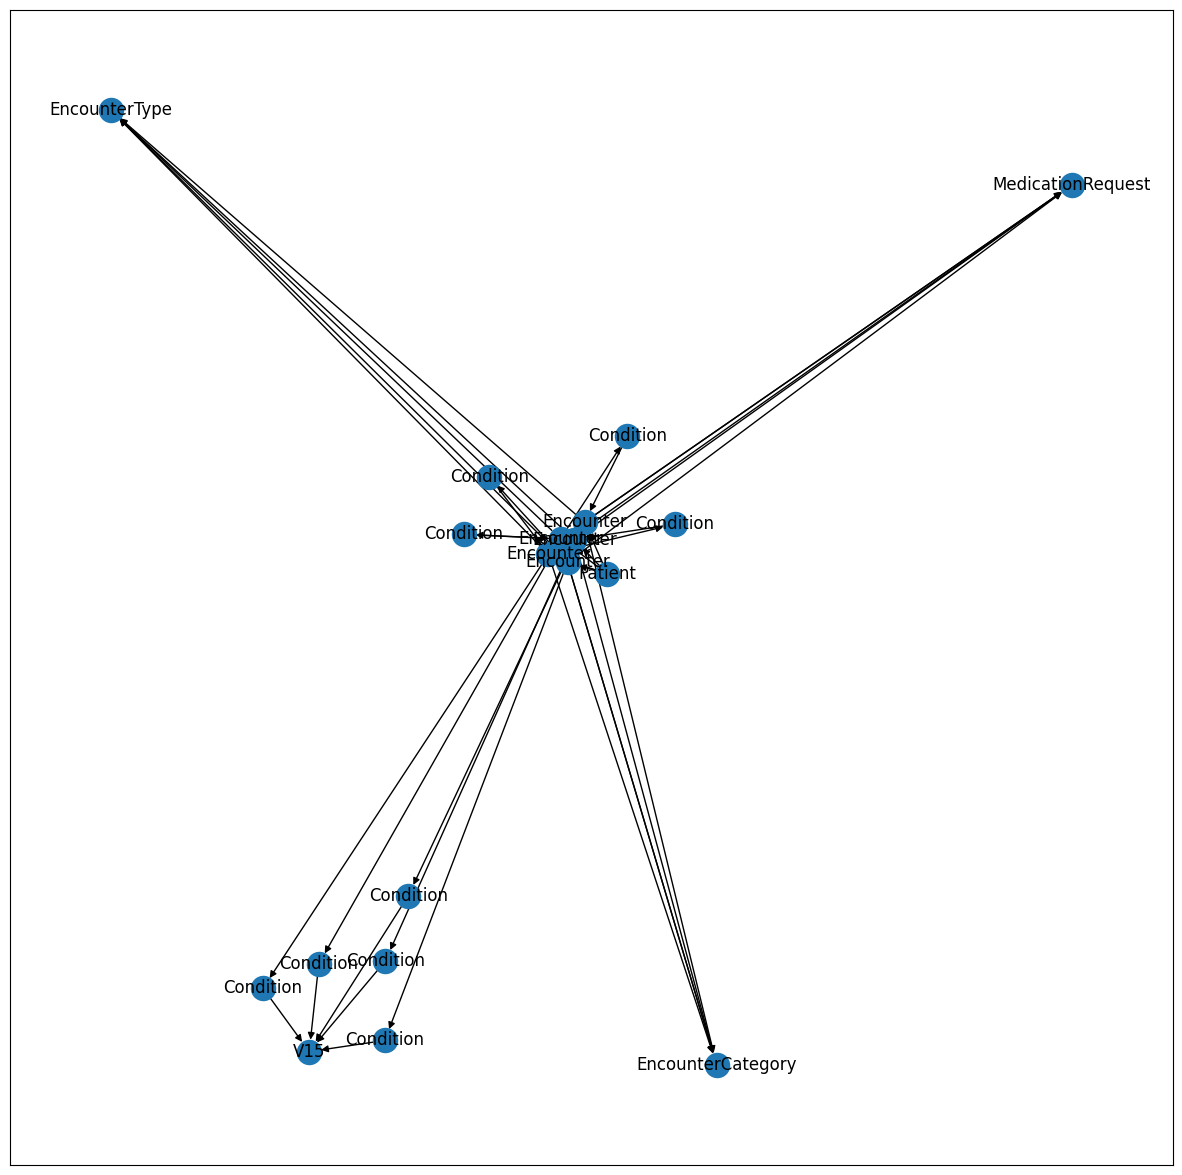

In [57]:
idx = 0
labels = dict()
for node in Gs_generated_processed[idx].nodes():
    labels[node] = Gs_generated_processed[idx].nodes[node]["label"]
plt.figure(1, figsize=(15, 15))
nx.draw_networkx(Gs_generated_processed[idx], labels=labels)
plt.savefig("generated_example.pdf", bbox_inches="tight")